# This notebook is to train models and create prediction.

In [4]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.callbacks import EarlyStopping


2023-11-12 13:14:47.364070: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def read_and_preprocess_image(image_path):
    """
    Function that reads the image stored as tif file at the input path
    """
    with rasterio.open(image_path) as src:
        data = src.read(1)
        return data, src.transform, src.crs, src.bounds

def load_from_metadata(csv_path):
    """
    Given a metadata csv, will return X array of images in matrix form and a Y array of labels 1 or 0.
    """
    data = pd.read_csv(csv_path)
    X = []
    Y = []
    for _ , row in data.iterrows():
        X.append(read_and_preprocess_image("data/"+row["path"]+".tif")[0])
        Y.append(int(row["plume"]=="yes"))

    return np.array(X), np.array(Y)

In [5]:
def old_cnn_model():
    """
    Returns a compiled keras Conv2D model. This specific model is not used.

    :param tuple input_shape: shape of ONE example as passed to the first
    :param int num_classes: number of output classes as passed to the las
    """

    model = keras.models.Sequential()

    model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=(64,64,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [22]:
def cnn_model():
    """
    Returns a compiled keras Conv2D model
    :param tuple input_shape: shape of ONE example as passed to the first
    :param int num_classes: number of output classes as passed to the las
    """
    model = keras.models.Sequential()

    model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=(64,64,1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss="binary_crossentropy",
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [23]:
X, Y = load_from_metadata("data/new_metadata.csv")
X = X / X.max()

seed = 42
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.8,shuffle=True,random_state=seed)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=8) # So that we 

model = cnn_model()
history = model.fit(x_train,y_train,epochs=50,callbacks=[callback],validation_data=(x_test,y_test))

Epoch 1/50
43/43 [==============================] - 15s 317ms/step - loss: 0.8471 - accuracy: 0.6853 - val_loss: 0.7026 - val_accuracy: 0.4797
Epoch 2/50
43/43 [==============================] - 13s 308ms/step - loss: 0.6512 - accuracy: 0.7355 - val_loss: 0.7082 - val_accuracy: 0.4826
Epoch 3/50
43/43 [==============================] - 14s 314ms/step - loss: 0.5557 - accuracy: 0.7493 - val_loss: 0.6923 - val_accuracy: 0.4826
Epoch 4/50
43/43 [==============================] - 14s 318ms/step - loss: 0.4982 - accuracy: 0.7725 - val_loss: 0.6299 - val_accuracy: 0.6134
Epoch 5/50
43/43 [==============================] - 14s 319ms/step - loss: 0.4389 - accuracy: 0.7951 - val_loss: 0.4982 - val_accuracy: 0.8198
Epoch 6/50
43/43 [==============================] - 14s 314ms/step - loss: 0.4142 - accuracy: 0.8161 - val_loss: 0.4606 - val_accuracy: 0.8140
Epoch 7/50
43/43 [==============================] - 13s 312ms/step - loss: 0.4019 - accuracy: 0.8212 - val_loss: 0.4426 - val_accuracy: 0.7878

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        16448     
                                                                 
 conv2d_3 (Conv2D)           (None, 31, 31, 64)        36928     
                                                        

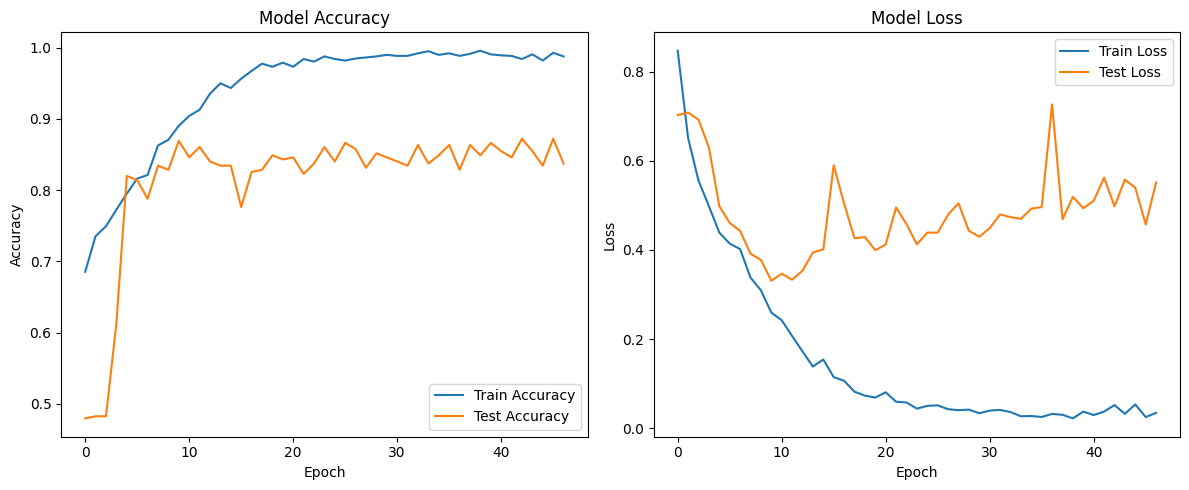

In [129]:
# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Test Accuracy")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Test Loss")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show();

In [118]:
import os

images = [read_and_preprocess_image("test data/images/"+image_path)[0] for image_path in os.listdir("test data/images")]

images = np.array(images)
outs = model.predict(images/images.max())

paths = os.listdir("test data/images")
paths = np.array(paths).reshape(-1,1)

paths = [ p[0] for p in paths]
paths

outs = [ o[0] for o in outs]
outs


out_csv = pd.DataFrame({"path":paths,
                        "label":outs})

4/4 [==============================] - 0s 71ms/step


> We now save the predition dataframe to a CSV file

In [120]:
out_csv.to_csv("data_test_prediction.csv")

In [121]:
def cnn_model_pos():
 model = keras.models.Sequential()

 model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=(64,64,1)))
 model.add(Conv2D(64, (3, 3), activation='relu'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.3))

 model.add(Conv2D(64, (2, 2), activation='relu', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.3))

 model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
 model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
#  model.add(BatchNormalization())
 model.add(Flatten())
 model.add(Dense(512, activation='linear'))
 model.add(Dropout(0.2))
 model.add(Dense(2,activation='linear'))

 sgd = SGD(learning_rate=0.05)

 model.compile(loss="mse",
               optimizer=sgd,)
 return model

In [133]:
def load_coord_from_metadata(csv_path):
    data = pd.read_csv(csv_path)
    X = []
    Y = []
    for _ , row in data.iterrows():
        if row["plume"]=="no":
            continue
        X.append(read_and_preprocess_image("data/"+row["path"]+".tif")[0])
        Y.append([row["coord_x"],row["coord_y"]])

    return np.array(X), np.array(Y)

In [134]:
xx, yy = load_coord_from_metadata("data/metadata.csv")

seed = 42
from sklearn.model_selection import train_test_split
xx_train, xx_test, yy_train, yy_test = train_test_split(xx/xx.max(),yy/64,train_size=0.8,shuffle=True,random_state=seed)

pos_model = cnn_model_pos()
history = pos_model.fit(xx_train,yy_train,epochs=30,validation_data=(xx_test,yy_test))

Epoch 1/30
6/6 [==============================] - 3s 327ms/step - loss: 0.1665 - val_loss: 0.2289
Epoch 2/30
6/6 [==============================] - 2s 302ms/step - loss: 0.1273 - val_loss: 0.1060
Epoch 3/30
6/6 [==============================] - 2s 310ms/step - loss: 0.0912 - val_loss: 0.0980
Epoch 4/30
6/6 [==============================] - 2s 310ms/step - loss: 0.1053 - val_loss: 0.1067
Epoch 5/30
6/6 [==============================] - 2s 360ms/step - loss: 0.0927 - val_loss: 0.0920
Epoch 6/30
6/6 [==============================] - 2s 325ms/step - loss: 0.0877 - val_loss: 0.0904
Epoch 7/30
6/6 [==============================] - 2s 319ms/step - loss: 0.0831 - val_loss: 0.0892
Epoch 8/30
6/6 [==============================] - 2s 297ms/step - loss: 0.0846 - val_loss: 0.1047
Epoch 9/30
6/6 [==============================] - 2s 305ms/step - loss: 0.0828 - val_loss: 0.0847
Epoch 10/30
6/6 [==============================] - 2s 337ms/step - loss: 0.0793 - val_loss: 0.0922
Epoch 11/30
6/6 [==

In [136]:
pred = pos_model.predict(xx_train)

M = 10
for i in range(M):
    print(f"pred: {pred[i][0]*64},{pred[i][1]*64} vs real: {yy[i][0]},{yy[i][1]}")

6/6 [==============================] - 1s 79ms/step
pred: 30.550384521484375,28.122821807861328 vs real: 24,47
pred: 24.687562942504883,24.558338165283203 vs real: 42,37
pred: 27.323028564453125,26.132431030273438 vs real: 58,15
pred: 23.779518127441406,15.802200317382812 vs real: 28,62
pred: 26.99643325805664,20.274585723876953 vs real: 59,44
pred: 29.324115753173828,12.507591247558594 vs real: 23,15
pred: 17.43588638305664,12.948047637939453 vs real: 21,-2
pred: 30.587799072265625,22.62081527709961 vs real: 37,56
pred: 22.738323211669922,27.67099380493164 vs real: 41,64
pred: 27.01233673095703,13.288604736328125 vs real: 63,65


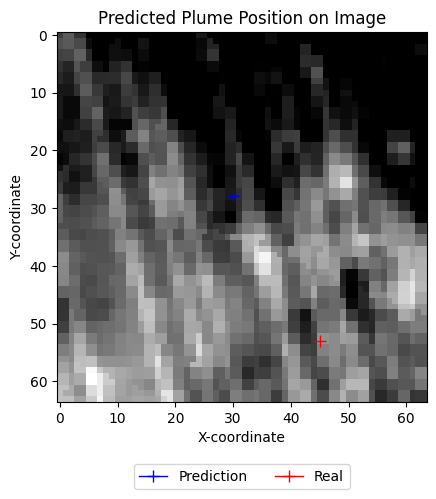

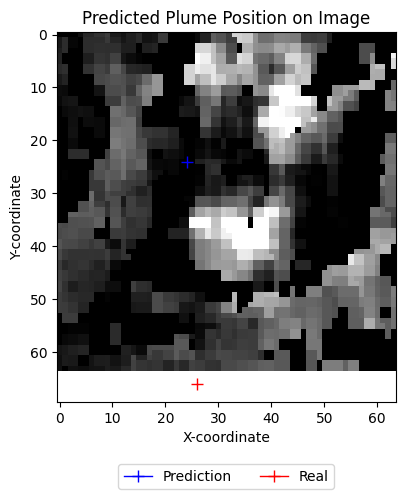

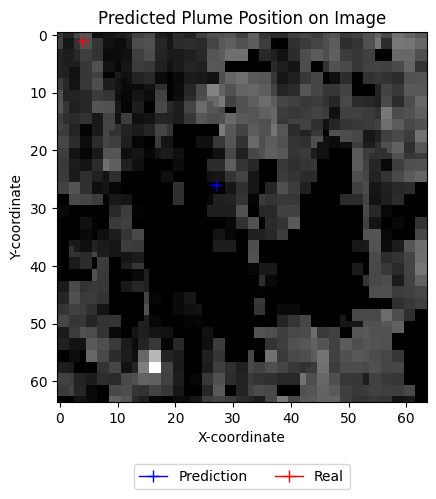

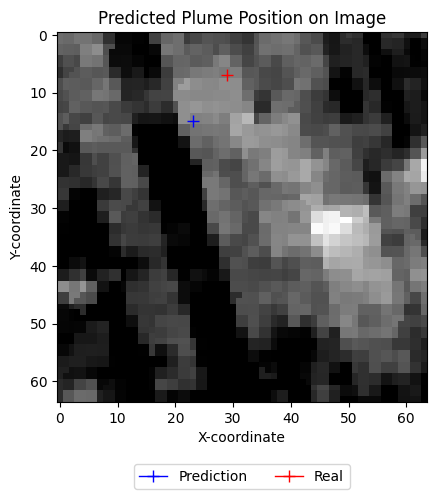

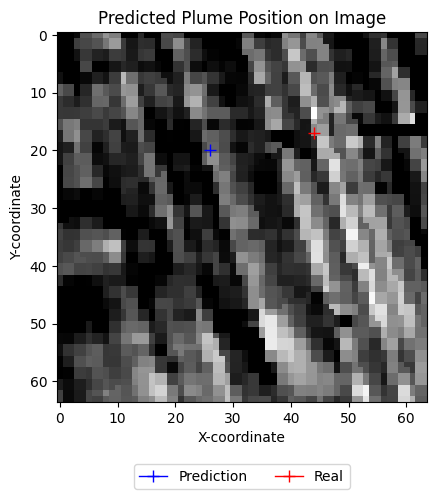

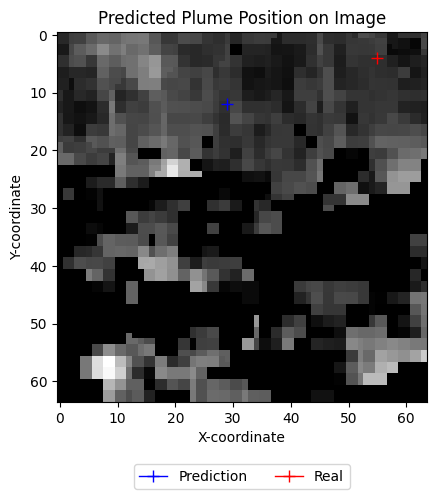

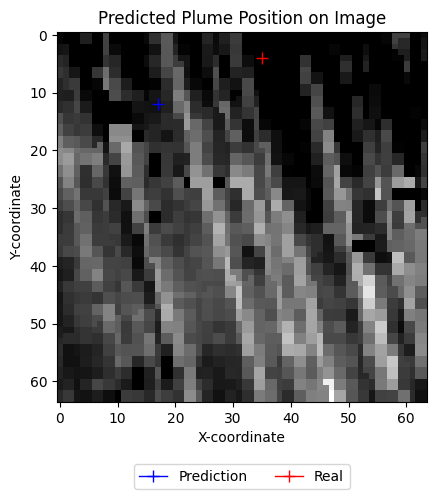

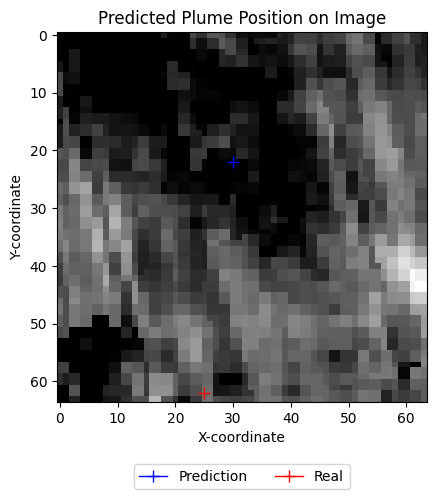

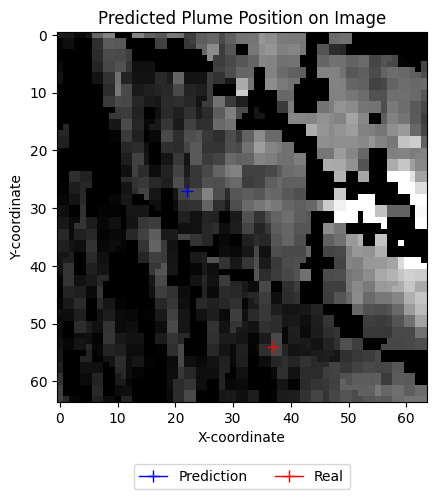

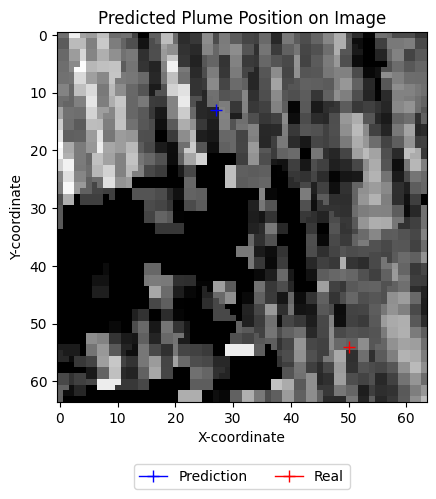

In [137]:
import matplotlib.pyplot as plt
M = 10
for i in range(M):
    plt.imshow(xx[i],cmap="gray")
    plt.plot(int(pred[i][0]*64),int(pred[i][1]*64),c="b",label="Prediction",marker="+",linewidth=1,markersize=8)
    plt.plot(int(yy_test[i][0]*64),int(yy_test[i][1]*64),c='r',label="Real",marker="+",linewidth=1,markersize=8)

    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.title('Predicted Plume Position on Image')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()